# Task 1


In [14]:
from scipy.sparse import csc_matrix, coo_matrix
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt
import numpy as np
import math
import zipfile

In [15]:
def construct_X(M, alphas, Np = None):
    # choose an appropriate Value for Np
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        if Np % 2 == 0:
            Np += 1
    
    # Define the coordinate system
    extent = (M-1)/2
    j_a, j_b = np.mgrid[-extent:extent+1, -extent:extent+1]
    C = np.row_stack([j_a.flatten(), j_b.flatten()])
    
    # Convert angles to radians and create unit vectors
    alphas = np.deg2rad(alphas)
    n = np.row_stack([-np.sin(alphas), np.cos(alphas)])

    # Project pixels onto sensor array
    p = (n.T @ C) + ((Np-1)/2)
    p_split_f, p_split_i = np.modf(p)
    
    # Calculate weights and indices
    w0 = 1 - p_split_f
    w1 = p_split_f
    i_0 = p_split_i.astype(int)
    i_1 = i_0 + 1

    # Adjust indices for multiple projections
    for i in range(len(alphas)):
        i_0[i,:] += Np * i
        i_1[i,:] += Np * i
    
    # Flatten arrays for sparse matrix construction
    i_indices = np.concatenate([i_0, i_1]).flatten()
    j_indices = np.tile(np.arange(C.shape[1]), 2*len(alphas))
    weights = np.concatenate([w0, w1]).flatten()

    # Construct sparse matrix
    X = coo_matrix((weights, (i_indices, j_indices)), 
                   shape=(Np * len(alphas), C.shape[1]), 
                   dtype=np.float32)
    
    return X

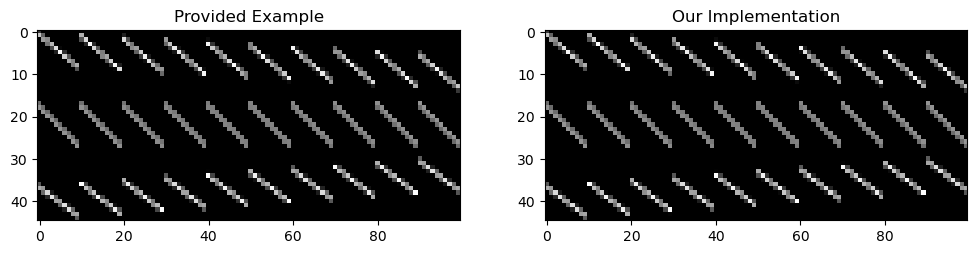

Sparsity of X: 0.007273


In [17]:
# Unzip the file 
if not os.path.exists('hs_tomography'):
    with zipfile.ZipFile('hs_tomography.zip', 'r') as zip_ref:
        zip_ref.extractall()

# Test visualization
test_vis = construct_X(10, [-33, 1, 42])

# Load the example matrix
X_example = np.load('hs_tomography/X_example.npy')

# Plot both matrices for comparison
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(X_example, cmap='gray', interpolation='nearest')
plt.title("Provided Example")
plt.subplot(122)
plt.imshow(test_vis.toarray(), cmap='gray', interpolation='nearest')
plt.title("Our Implementation")
plt.show()

# Calculate and print sparsity for the full-size problem
alphas_195 = np.load('hs_tomography/alphas_195.npy')  # Load the full set of angles
X_full = construct_X(195, alphas_195, 275)
sparsity = X_full.nnz / (X_full.shape[0] * X_full.shape[1])
print(f"Sparsity of X: {sparsity:.6f}")

# Task 2

Small version:


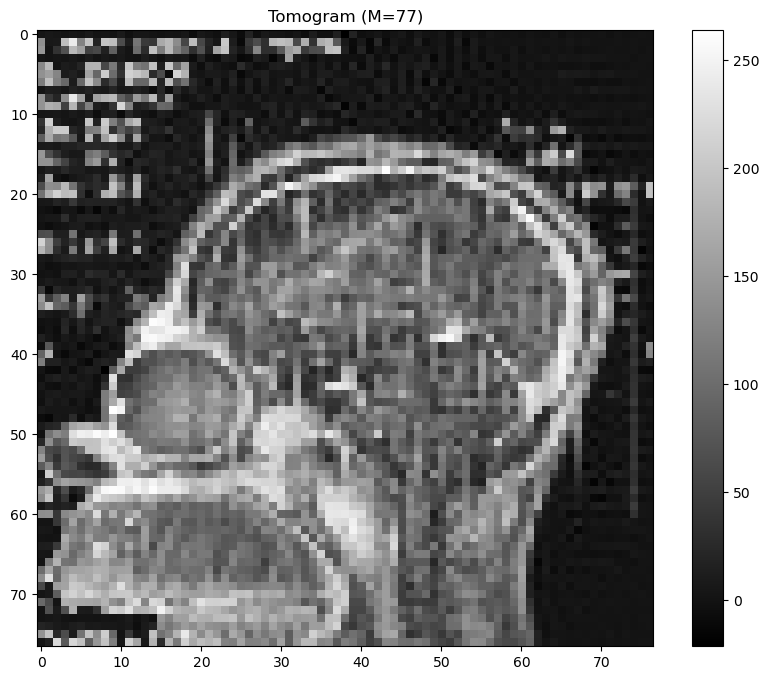

Number of non-zero entries: 1066978
Sparsity: 0.981656

Large version:


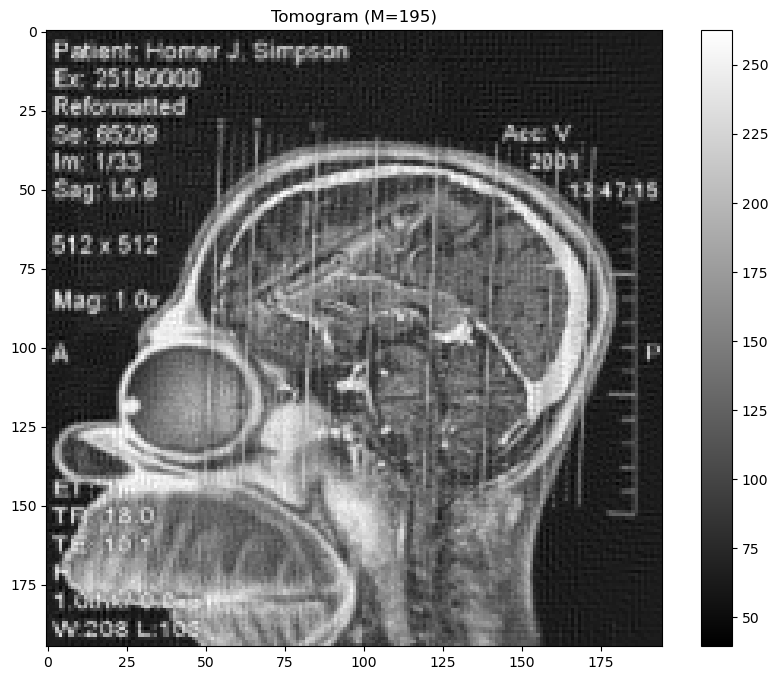

Number of non-zero entries: 13612950
Sparsity: 0.992727


In [25]:
import os
import numpy as np
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt

def coo_to_csc(coo):
    if isinstance(coo, csc_matrix):
        return coo
    else:
        return coo.tocsc()

def show_tomogram(X, y, M):
    beta = lsqr(X, y, atol=1e-05, btol=1e-05)[0]
    
    mu = np.reshape(beta, (M, M))
    plt.figure(figsize=(10, 8))
    plt.imshow(mu, cmap="gray", interpolation="nearest")
    plt.colorbar()
    plt.title(f"Tomogram (M={M})")
    plt.show()

def print_sparsity(X):
    print(f"Number of non-zero entries: {X.nnz}")
    print(f"Sparsity: {1 - (X.nnz / (X.shape[0] * X.shape[1])):.6f}")

# Ensure we're in the correct directory
if not os.path.exists('hs_tomography'):
    os.chdir(os.path.dirname(os.path.abspath(__file__)))

# Small version
print("Small version:")
alphas_77 = np.load("hs_tomography/alphas_77.npy")
y_77 = np.load("hs_tomography/y_77.npy")
X_77 = csc_matrix(np.load("hs_tomography/X_77.npy", allow_pickle=True).item())
M_77 = 77
show_tomogram(X_77, y_77, M_77)
print_sparsity(X_77)

# Large version
print("\nLarge version:")
alphas_195 = np.load("hs_tomography/alphas_195.npy")
y_195 = np.load("hs_tomography/y_195.npy")
X_195 = coo_to_csc(construct_X(195, alphas_195, 275))
M_195 = 195
show_tomogram(X_195, y_195, M_195)
print_sparsity(X_195)

Diagnosis: H.S.'s headache is caused by a crayon lodged in his brain since childhood.
Treatment:

Remove crayon surgically (but warn patient about potential increase in intelligence).
Prescribe daily doses of donuts and TV to maintain comfortable lifestyle.
Regular check-ups at Moe's for "mental health support."
(Simpsons S9E12)


# Task 3

In [14]:
# option small
M = 77
Np = 109
n_alphas = 90

In [15]:
# option big
M = 195
Np = 275
n_alphas = 179

Tomogram for 179 angles:


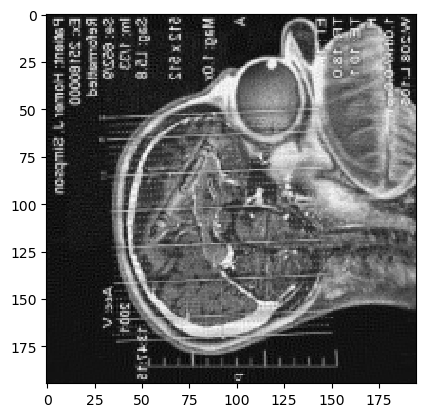

Tomogram for 170 angles:


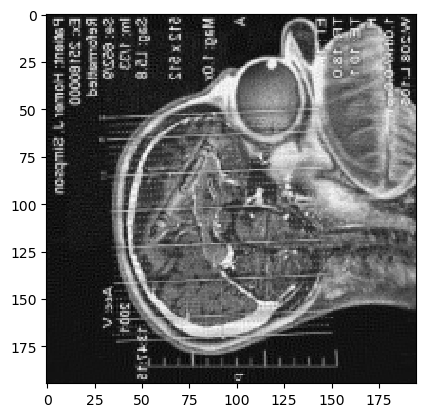

Tomogram for 161 angles:


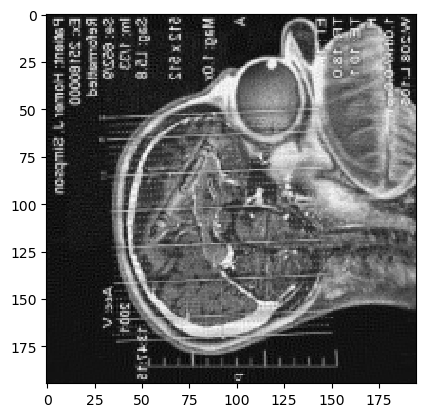

Tomogram for 152 angles:


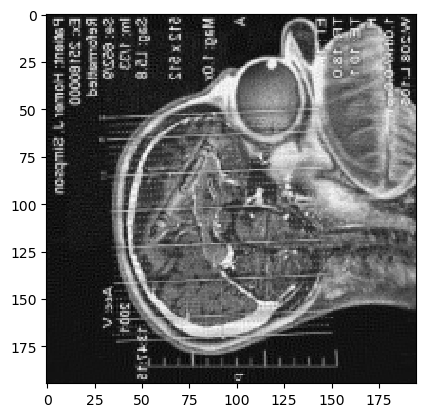

Tomogram for 143 angles:


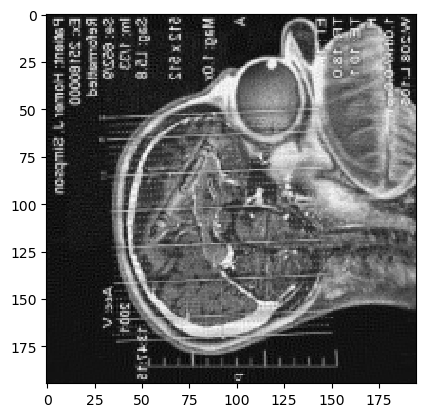

Tomogram for 134 angles:


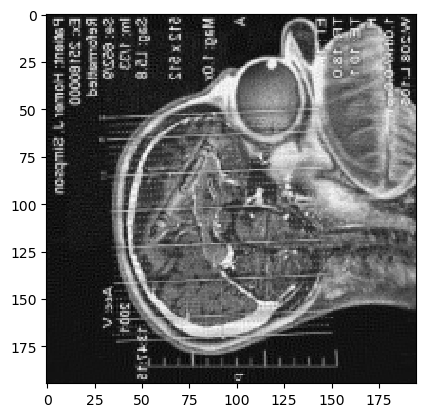

Tomogram for 125 angles:


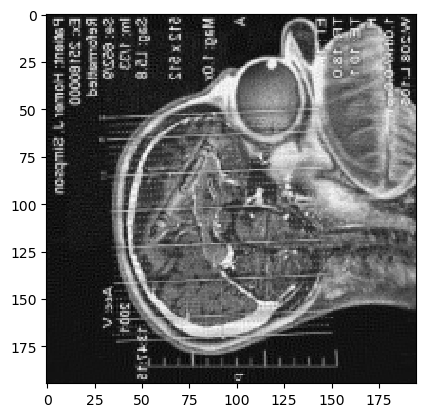

Tomogram for 116 angles:


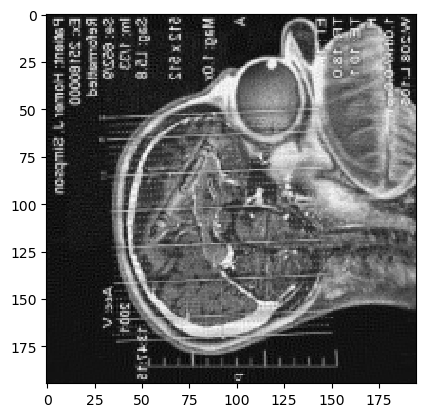

Tomogram for 107 angles:


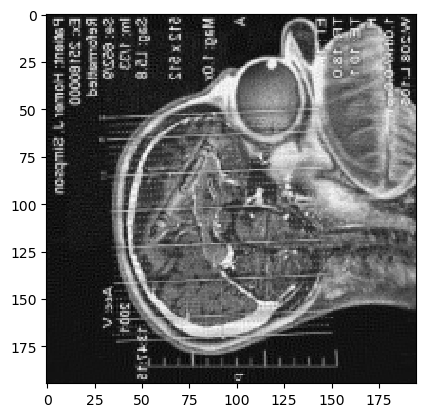

Tomogram for 98 angles:


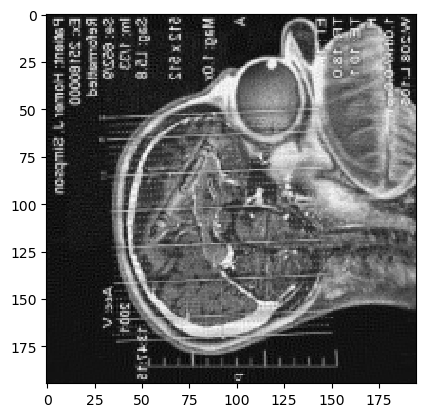

Tomogram for 89 angles:


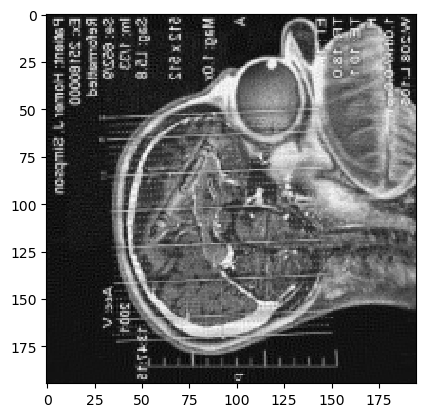

Tomogram for 80 angles:


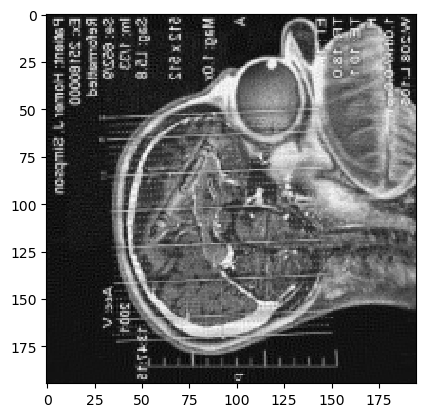

Tomogram for 71 angles:


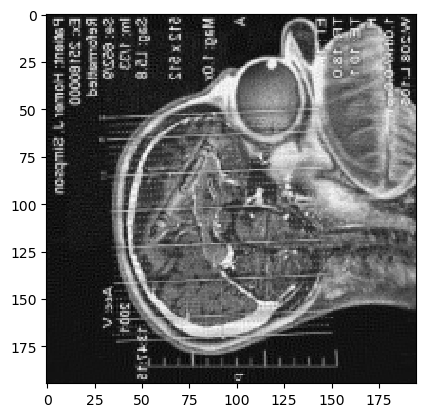

Tomogram for 62 angles:


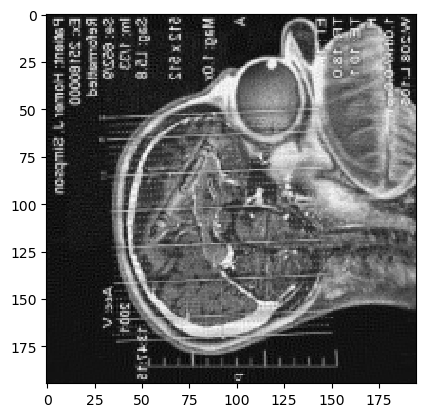

Tomogram for 53 angles:


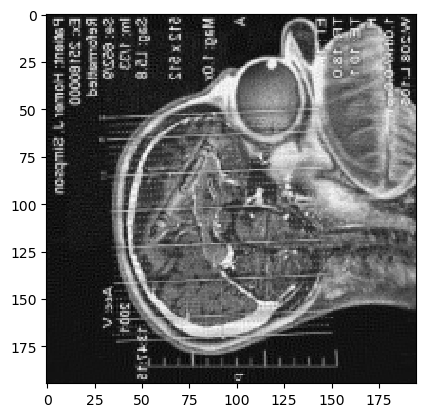

Tomogram for 44 angles:


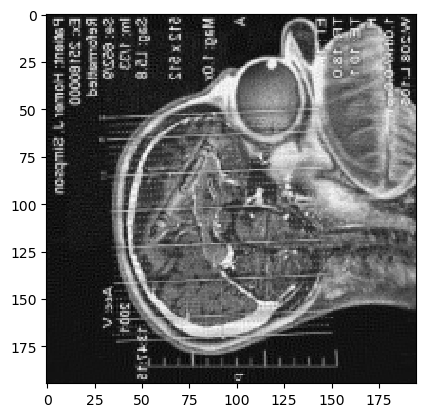

Tomogram for 35 angles:


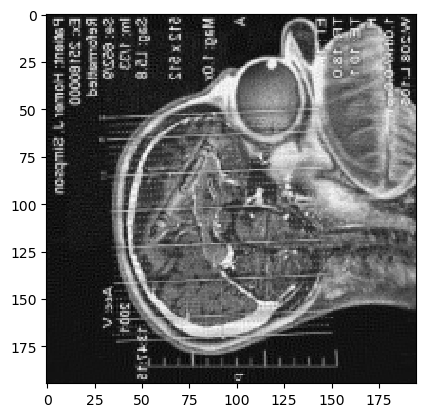

Tomogram for 26 angles:


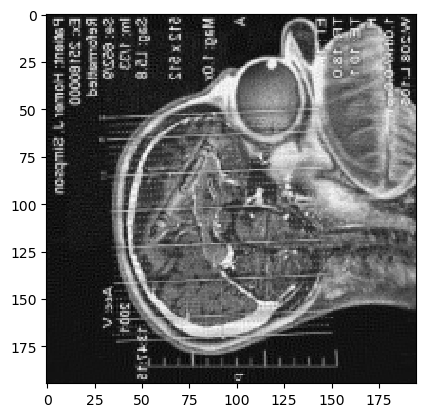

Tomogram for 17 angles:


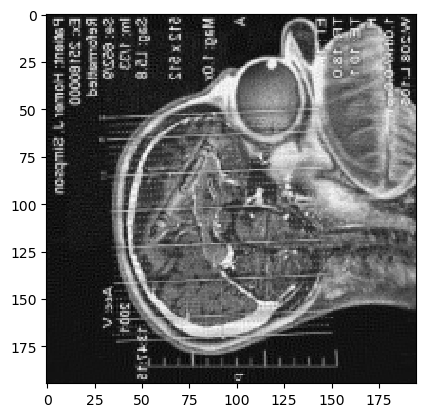

Tomogram for 8 angles:


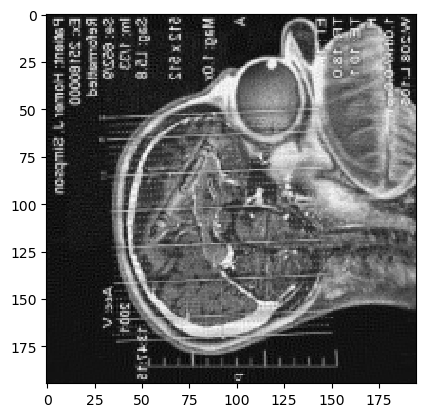

In [16]:
for n_alphas_ in range(n_alphas, 1, -1 * math.ceil(n_alphas / 20)):
    indices = np.linspace(0, len(alphas) - 1, n_alphas_, dtype=int)
    alphas_ = alphas[indices]
    y_ = y[indices]
    x_ = coo_to_csc(construct_X(M, alphas_, Np))
    print(f"Tomogram for {n_alphas_} angles:")
    show_tomogram(X, y)